In [1]:
# Cell 1: imports, data classes, core scheduler

import math
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try widgets (for buttons). If not available, we'll just print a note.
try:
    import ipywidgets as widgets
    from IPython.display import display
    HAVE_WIDGETS = True
except ImportError:
    HAVE_WIDGETS = False
    print("ipywidgets not available – UI buttons will be disabled.")

# --- plotting style (paper-ish) ---
plt.rcParams.update({
    "figure.dpi": 130,
    "savefig.dpi": 300,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.0,
    "axes.facecolor": "white",
    "grid.color": "0.7",
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "axes.grid": True,
    "font.size": 11,
    "font.family": "serif",
    "lines.linewidth": 2.0,
    "lines.markersize": 6,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.edgecolor": "0.3",
})


@dataclass
class Task:
    name: str
    period_ms: float
    exec_ms: float        # base execution time at alpha = 1
    deadline_ms: float    # relative deadline


@dataclass
class Job:
    task: Task
    release: float
    deadline: float
    remaining: float      # remaining exec time
    scheduler: str        # EDF / RM / FIFO
    alpha: float          # load factor
    id: int               # unique within task to break ties


def simulate_one_scheduler(
        tasks: List[Task],
        scheduler_name: str,
        sim_time_ms: float,
        alpha_load: float,
        dt_ms: float = 1.0,
) -> Tuple[List[Dict], Dict]:
    """
    Simulate one CPU with preemptive EDF / RM / FIFO.
    Returns (jobs_list, effort_dict).
    jobs_list is a list of dictionaries with job metrics.
    effort_dict holds aggregator metrics for plotting.
    """

    # Scale execution by alpha
    scaled_tasks = []
    for t in tasks:
        scaled_tasks.append(
            Task(
                name=t.name,
                period_ms=t.period_ms,
                exec_ms=t.exec_ms * alpha_load,
                deadline_ms=t.deadline_ms,
            )
        )

    # Utilization of this task set under the given alpha
    util = sum(t.exec_ms / t.period_ms for t in scaled_tasks)

    # Per-task next release time and instance counter
    next_release = {t.name: 0.0 for t in scaled_tasks}
    job_counter = {t.name: 0 for t in scaled_tasks}

    ready: List[Job] = []
    all_records: List[Dict] = []

    # Effort proxy
    max_ready_len = 0
    dispatch_count = 0

    t = 0.0

    def choose_job_edf(ready_jobs: List[Job]) -> Job:
        return min(ready_jobs, key=lambda j: (j.deadline, j.release, j.id))

    # RM priority based on period (shorter period = higher priority)
    period_map = {t.name: t.period_ms for t in scaled_tasks}

    def choose_job_rm(ready_jobs: List[Job]) -> Job:
        return min(
            ready_jobs,
            key=lambda j: (period_map[j.task.name], j.release, j.id)
        )

    def choose_job_fifo(ready_jobs: List[Job]) -> Job:
        return min(ready_jobs, key=lambda j: (j.release, j.id))

    if scheduler_name == "EDF":
        chooser = choose_job_edf
    elif scheduler_name == "RM":
        chooser = choose_job_rm
    else:
        chooser = choose_job_fifo

    # Main simulation loop
    while t < sim_time_ms + 1e-9:
        # 1) Release new jobs
        for task in scaled_tasks:
            if t + 1e-9 >= next_release[task.name]:
                # Release a new job
                job_counter[task.name] += 1
                j = Job(
                    task=task,
                    release=next_release[task.name],
                    deadline=next_release[task.name] + task.deadline_ms,
                    remaining=task.exec_ms,
                    scheduler=scheduler_name,
                    alpha=alpha_load,
                    id=job_counter[task.name],
                )
                ready.append(j)
                next_release[task.name] += task.period_ms

        # 2) If no jobs, just advance time
        if not ready:
            t += dt_ms
            continue

        # Effort: how many decisions + how long queue gets
        max_ready_len = max(max_ready_len, len(ready))
        dispatch_count += 1

        # 3) Choose job according to policy
        cur_job = chooser(ready)

        # 4) Execute for dt (or until completion)
        exec_step = min(dt_ms, cur_job.remaining)
        cur_job.remaining -= exec_step
        t += exec_step

        # 5) If job finished, record metrics
        if cur_job.remaining <= 1e-9:
            ready.remove(cur_job)
            finish = t
            response = finish - cur_job.release
            tardiness = max(0.0, finish - cur_job.deadline)
            miss = 1 if finish > cur_job.deadline + 1e-9 else 0

            all_records.append({
                "scheduler": scheduler_name,
                "task": cur_job.task.name,
                "alpha": alpha_load,
                "release": cur_job.release,
                "finish": finish,
                "deadline": cur_job.deadline,
                "response": response,
                "tardiness": tardiness,
                "miss": miss,
            })

    effort = {
        "scheduler": scheduler_name,
        "alpha": alpha_load,
        "util": util,
        "max_ready_len": max_ready_len,
        "num_dispatch": dispatch_count,
    }

    return all_records, effort

In [2]:
# Cell 2: summarization + plotting helpers

def summarize_jobs_with_metrics(jobs: List[Dict]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    From raw job records, build:
    - df_jobs (raw)
    - df_sched (metrics aggregated by scheduler + alpha)
    - df_task  (metrics aggregated by scheduler + alpha + task)
    """
    df_jobs = pd.DataFrame(jobs)
    if df_jobs.empty:
        raise ValueError("No jobs collected in simulation.")

    # Per scheduler + alpha + task
    grp_task = df_jobs.groupby(["scheduler", "alpha", "task"])
    df_task = grp_task.agg(
        avg_latency_ms=("response", "mean"),
        avg_tardiness_ms=("tardiness", "mean"),
        miss_ratio=("miss", "mean"),
        n_jobs=("response", "count"),
    ).reset_index()

    # Per scheduler + alpha (average over tasks)
    grp_sched = df_jobs.groupby(["scheduler", "alpha"])
    df_sched = grp_sched.agg(
        avg_latency_ms=("response", "mean"),
        avg_tardiness_ms=("tardiness", "mean"),
        miss_ratio=("miss", "mean"),
        n_jobs=("response", "count"),
    ).reset_index()

    return df_jobs, df_sched, df_task


def plot_dashboard(df_sched: pd.DataFrame,
                   df_task: pd.DataFrame,
                   df_effort: pd.DataFrame,
                   title_prefix: str):
    """
    2x2 figure:
      (1) avg latency vs load           (per scheduler)
      (2) deadline miss ratio vs load   (per scheduler)
      (3) scheduler effort vs util      (per scheduler)
      (4) avg tardiness vs load         (per scheduler)
    Plus a second figure with per-task tardiness bars.
    """

    scheds = sorted(df_sched["scheduler"].unique())
    alphas = sorted(df_sched["alpha"].unique())

    colors = {
        "EDF": "#1f77b4",
        "RM": "#ff7f0e",
        "FIFO": "#2ca02c",
    }

    fig, axs = plt.subplots(2, 2, figsize=(11, 8))
    ax_lat, ax_miss, ax_eff, ax_tard = axs.ravel()

    # --- 1) latency vs alpha ---
    for s in scheds:
        sub = df_sched[df_sched["scheduler"] == s].sort_values("alpha")
        ax_lat.plot(sub["alpha"], sub["avg_latency_ms"],
                    marker="o", label=s, color=colors.get(s, None))
    ax_lat.set_title("Average response time vs load factor α")
    ax_lat.set_xlabel("Load factor α")
    ax_lat.set_ylabel("Average response time [ms]")
    ax_lat.legend(title="Scheduler")

    # --- 2) miss ratio vs alpha ---
    for s in scheds:
        sub = df_sched[df_sched["scheduler"] == s].sort_values("alpha")
        ax_miss.plot(sub["alpha"], sub["miss_ratio"],
                     marker="s", label=s, color=colors.get(s, None))
    ax_miss.set_title("Deadline miss ratio vs load factor α")
    ax_miss.set_xlabel("Load factor α")
    ax_miss.set_ylabel("Miss ratio")
    ax_miss.set_ylim(-0.02, 1.05)
    ax_miss.legend(title="Scheduler")

    # --- 3) effort vs utilization ---
    for s in scheds:
        sub = df_effort[df_effort["scheduler"] == s].sort_values("util")
        ax_eff.plot(sub["util"] * 100.0, sub["max_ready_len"],
                    marker="^", label=s, color=colors.get(s, None))
    ax_eff.set_title("Scheduler effort vs total utilization")
    ax_eff.set_xlabel("Total utilization U [%]")
    ax_eff.set_ylabel("Max ready-queue length (effort proxy)")
    ax_eff.legend(title="Scheduler")

    # --- 4) avg tardiness vs alpha ---
    for s in scheds:
        sub = df_sched[df_sched["scheduler"] == s].sort_values("alpha")
        ax_tard.plot(sub["alpha"], sub["avg_tardiness_ms"],
                     marker="d", label=s, color=colors.get(s, None))
    ax_tard.set_title("Average tardiness vs load factor α")
    ax_tard.set_xlabel("Load factor α")
    ax_tard.set_ylabel("Average tardiness [ms]")
    ax_tard.legend(title="Scheduler")

    fig.suptitle(title_prefix, fontsize=15, fontweight="bold")
    fig.tight_layout(rect=[0, 0.02, 1, 0.96])
    plt.show()

    # --- Per-task tardiness bars at highest alpha (all tasks) ---

    alpha_max = max(alphas)
    sched_ref = "EDF" if "EDF" in scheds else scheds[0]

    sub = df_task[(df_task["alpha"] == alpha_max)]
    if sub.empty:
        return

    plt.figure(figsize=(9, 4))
    width = 0.25
    x_tasks = sorted(sub["task"].unique())
    x = np.arange(len(x_tasks))

    for i, s in enumerate(scheds):
        ssub = sub[sub["scheduler"] == s]
        ssub = ssub.set_index("task").reindex(x_tasks)
        plt.bar(x + i*width,
                ssub["avg_tardiness_ms"],
                width=width,
                label=s,
                color=colors.get(s, None))

    plt.xticks(x + width, x_tasks)
    plt.ylabel(f"Average tardiness at α = {alpha_max} [ms]")
    plt.title("Per-task tardiness for each scheduler")
    plt.legend(title="Scheduler")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

In [ ]:
# Cell 3: generic EDF vs RM vs FIFO experiment (with button)

def run_generic_experiment(
        n_tasks: int,
        base_T: float,
        base_C: float,
        sim_time_ms: float,
        alpha_list: List[float],
) -> Tuple[List[Task], pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Build n_tasks identical tasks and run EDF/RM/FIFO for each α.
    """
    tasks = [
        Task(name=f"Task{i+1}", period_ms=base_T, exec_ms=base_C, deadline_ms=base_T)
        for i in range(n_tasks)
    ]

    all_jobs: List[Dict] = []
    effort_rows: List[Dict] = []

    for alpha in alpha_list:
        for sched in ["EDF", "RM", "FIFO"]:
            jobs, effort = simulate_one_scheduler(
                tasks, sched, sim_time_ms, alpha_load=alpha, dt_ms=1.0
            )
            all_jobs.extend(jobs)
            effort_rows.append(effort)

    df_jobs, df_sched, df_task = summarize_jobs_with_metrics(all_jobs)
    df_effort = pd.DataFrame(effort_rows)
    return tasks, df_jobs, df_sched, df_task, df_effort


def parse_alpha_list(text: str) -> List[float]:
    parts = [p.strip() for p in text.split(",") if p.strip()]
    vals: List[float] = []
    for p in parts:
        try:
            vals.append(float(p))
        except ValueError:
            print(f"Ignoring invalid α='{p}'")
    return vals if vals else [0.5, 0.75, 1.0, 1.25, 1.5]


def run_generic_from_ui(n_tasks, base_T, base_C, sim_time_ms, alpha_text):
    alpha_list = parse_alpha_list(alpha_text)

    print(f"Sensors: {n_tasks}")
    print(f"Base period T [ms]: {base_T}")
    print(f"Base exec C [ms]: {base_C}")
    print(f"Sim time [ms]: {sim_time_ms}")
    print(f"α list: {alpha_list}")

    tasks, df_jobs, df_sched, df_task, df_effort = run_generic_experiment(
        n_tasks, base_T, base_C, sim_time_ms, alpha_list
    )

    print("Total jobs:", len(df_jobs))
    df_jobs.to_csv("generic_jobs.csv", index=False)
    df_sched.to_csv("generic_summary_sched.csv", index=False)
    df_task.to_csv("generic_summary_task.csv", index=False)
    df_effort.to_csv("generic_effort.csv", index=False)
    print("Wrote CSV files: generic_jobs.csv, generic_summary_sched.csv, generic_summary_task.csv, generic_effort.csv")

    plot_dashboard(
        df_sched,
        df_task,
        df_effort,
        title_prefix="Generic task set: EDF vs RM vs FIFO",
    )


# --- Build widgets / button ---

if HAVE_WIDGETS:
    sensors_slider = widgets.IntSlider(value=4, min=1, max=40, step=1, description="Sensors:")
    T_slider = widgets.FloatSlider(value=200.0, min=10.0, max=1000.0, step=10.0,
                                   description="Period T [ms]:")
    C_slider = widgets.FloatSlider(value=5.0, min=0.5, max=50.0, step=0.5,
                                   description="Exec C [ms]:")
    sim_time_box = widgets.FloatText(value=60_000.0, description="Sim time [ms]:")
    alpha_box = widgets.Text(value="10,20,30,40,50", description="α list:")

    ui_row1 = widgets.HBox([sensors_slider, T_slider, C_slider])
    ui_row2 = widgets.HBox([sim_time_box, alpha_box])

    run_button = widgets.Button(
        description="▶ Run EDF Simulation",
        button_style="success",
        layout=widgets.Layout(width="220px"),
    )
    out_generic = widgets.Output()

    def on_run_clicked_generic(_):
        with out_generic:
            out_generic.clear_output()
            run_generic_from_ui(
                n_tasks=sensors_slider.value,
                base_T=T_slider.value,
                base_C=C_slider.value,
                sim_time_ms=sim_time_box.value,
                alpha_text=alpha_box.value,
            )

    run_button.on_click(on_run_clicked_generic)

    display(widgets.VBox([ui_row1, ui_row2, run_button, out_generic]))
else:
    print("Widgets not available. Call run_generic_from_ui(...) manually.")

In [ ]:
# Cell 4: project-specific experiment (Ultra, Sound, PIR, Button)

def build_project_tasks() -> List[Task]:
    return [
        Task("Ultra",  period_ms=200.0,  exec_ms=3.0,  deadline_ms=200.0),
        Task("Sound",  period_ms=2000.0, exec_ms=8.0,  deadline_ms=2000.0),
        Task("PIR",    period_ms=500.0,  exec_ms=1.0,  deadline_ms=100.0),
        Task("Button", period_ms=500.0,  exec_ms=1.0,  deadline_ms=150.0),
    ]


def run_project_experiment(sim_time_ms: float,
                           alpha_list: List[float]):
    tasks = build_project_tasks()
    print("Project task set:")
    for t in tasks:
        u = t.exec_ms / t.period_ms
        print(f"  {t.name}: T={t.period_ms} ms, C={t.exec_ms} ms, D={t.deadline_ms} ms, U={u:.3f}")

    all_jobs: List[Dict] = []
    effort_rows: List[Dict] = []

    for alpha in alpha_list:
        for sched in ["EDF", "RM", "FIFO"]:
            jobs, effort = simulate_one_scheduler(
                tasks, sched, sim_time_ms, alpha_load=alpha, dt_ms=1.0
            )
            all_jobs.extend(jobs)
            effort_rows.append(effort)

    df_jobs, df_sched, df_task = summarize_jobs_with_metrics(all_jobs)
    df_effort = pd.DataFrame(effort_rows)

    print("Total jobs (project):", len(df_jobs))
    df_jobs.to_csv("project_jobs.csv", index=False)
    df_sched.to_csv("project_summary_sched.csv", index=False)
    df_task.to_csv("project_summary_task.csv", index=False)
    df_effort.to_csv("project_effort.csv", index=False)
    print("Wrote CSV files: project_jobs.csv, project_summary_sched.csv, project_summary_task.csv, project_effort.csv")

    plot_dashboard(
        df_sched,
        df_task,
        df_effort,
        title_prefix="Project EDF simulation – ESP32 sensor node",
    )


# --- Widgets / button for project experiment ---

if HAVE_WIDGETS:
    proj_sim_time_box = widgets.FloatText(value=60_000.0, description="Sim time [ms]:")
    proj_alpha_box = widgets.Text(value="0.5,0.75,1.0,1.25,1.5", description="α list:")

    proj_run_button = widgets.Button(
        description="▶ Run Project EDF",
        button_style="info",
        layout=widgets.Layout(width="220px"),
    )
    out_project = widgets.Output()

    def on_run_clicked_project(_):
        with out_project:
            out_project.clear_output()
            alphas = parse_alpha_list(proj_alpha_box.value)
            print("Project α list:", alphas)
            run_project_experiment(
                sim_time_ms=proj_sim_time_box.value,
                alpha_list=alphas,
            )

    proj_run_button.on_click(on_run_clicked_project)

    display(widgets.VBox([
        widgets.HBox([proj_sim_time_box, proj_alpha_box]),
        proj_run_button,
        out_project
    ]))
else:
    print("Widgets not available. Call run_project_experiment(...) manually.")

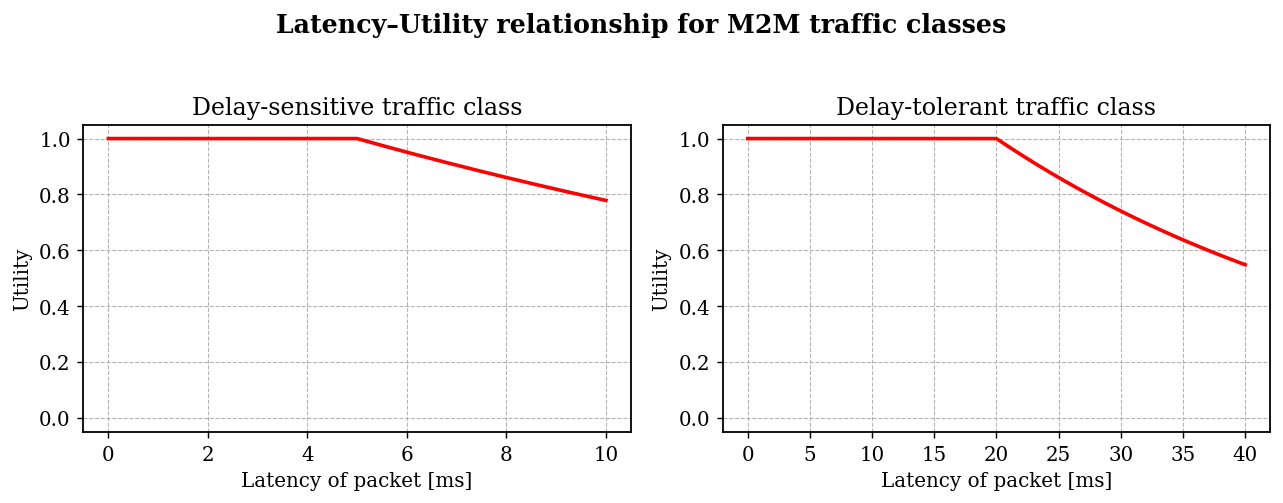

In [5]:
# Cell 5: latency–utility relationship plots (like your slide)

def latency_utility_delay_sensitive(latencies_ms: np.ndarray,
                                    a: float = 50.0,
                                    b: float = 5.0) -> np.ndarray:
    """
    Very steep drop near b (≈ step at 5 ms).
    u(l) = 1 for l <= b, then decays quickly.
    """
    u = np.ones_like(latencies_ms, dtype=float)
    idx = latencies_ms > b
    u[idx] = np.exp(-a * (latencies_ms[idx] - b) / 1000.0)
    return u


def latency_utility_delay_tolerant(latencies_ms: np.ndarray,
                                   a: float = 0.3,
                                   b: float = 20.0) -> np.ndarray:
    """
    Smooth convex decay starting around 20 ms.
    """
    u = np.ones_like(latencies_ms, dtype=float)
    idx = latencies_ms > b
    u[idx] = np.exp(-a * (latencies_ms[idx] - b) / 10.0)
    return u


lat1 = np.linspace(0, 10, 400)
lat2 = np.linspace(0, 40, 400)

u1 = latency_utility_delay_sensitive(lat1, a=50.0, b=5.0)
u2 = latency_utility_delay_tolerant(lat2, a=0.3, b=20.0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(lat1, u1, color="red")
ax1.set_title("Delay-sensitive traffic class")
ax1.set_xlabel("Latency of packet [ms]")
ax1.set_ylabel("Utility")
ax1.set_ylim(-0.05, 1.05)

ax2.plot(lat2, u2, color="red")
ax2.set_title("Delay-tolerant traffic class")
ax2.set_xlabel("Latency of packet [ms]")
ax2.set_ylabel("Utility")
ax2.set_ylim(-0.05, 1.05)

fig.suptitle("Latency–Utility relationship for M2M traffic classes",
             fontsize=14, fontweight="bold")
fig.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.show()